# Pipeline Testing

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import torch
import numpy as np
from torch import nn
from torch.nn import Linear
import pytorch_lightning as pl
from pytorch_lightning import LightningModule
from pytorch_lightning.callbacks import ModelCheckpoint
import yaml
import importlib
sys.path.append('..')

In [3]:
MODEL_LIBRARY = "/global/homes/d/danieltm/ExaTrkX/Tracking-ML-Exa.TrkX/src/Pipelines/Examples/LightningModules"
ARTIFACT_LIBRARY = "/global/cscratch1/sd/danieltm/ExaTrkX/lightning_checkpoints"
sys.path.append(MODEL_LIBRARY)

# Preprocessing

## Data Loading

In [6]:
with open("LightningModules/Processing/prepare_feature_store.yaml") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [7]:
preprocess_dm = FeatureStore(config)

In [8]:
preprocess_dm.prepare_data()

Loading detector...
Detector loaded.
Writing outputs to /global/cscratch1/sd/danieltm/ExaTrkX/trackml/feature_store_endcaps
/global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001000
Preparing 1000
Layerless truth graph built for /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001000 with size (2, 123429)
Cell features for 1000
Loading event /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001000 with a 0 pT cut
/global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001001
Preparing 1001
Layerless truth graph built for /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001001 with size (2, 91386)
Cell features for 1001
Loading event /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001001 with a 0 pT cut
/global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001002
Preparing 1002
Layerless truth graph built for /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001002 with size (2, 1289

KeyboardInterrupt: 

In [11]:
data = torch.load("/global/cscratch1/sd/danieltm/ExaTrkX/trackml/feature_store_endcaps/1000")

In [13]:
data

Data(cell_data=[103305, 9], event_file=/global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001000, hid=[103305], layerless_true_edges=[2, 123429], layers=[103305], pid=[103305], x=[103305, 3])

# Embedding

## Model Loading

In [3]:
with open("LightningModules/Embedding/train_embedding.yaml") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [4]:
model = LayerlessEmbedding(config)

Optionally load the Weights & Biases logger

In [3]:
wandb_dir = "/global/cscratch1/sd/danieltm/ExaTrkX/wandb_data"
wandb_logger = WandbLogger(project="EmbeddingStudy", group="LayerlessEndcaps", log_model=True, save_dir = wandb_dir)

In [6]:
trainer = pl.Trainer(max_epochs = config['max_epochs'], gpus=1, logger=wandb_logger, callbacks=stringlist_to_classes(config["callbacks"]))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [7]:
trainer.fit(model)

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Currently logged in as: murnanedaniel (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.10.2
wandb: Run data is saved locally in /global/cscratch1/sd/danieltm/ExaTrkX/wandb_data/wandb/run-20201013_111443-hd6lqvip
wandb: Syncing run worthy-frog-58


Set SLURM handle signals.

  | Name      | Type       | Params
-----------------------------------------
0 | layers    | ModuleList | 1 M   
1 | emb_layer | Linear     | 4 K   
2 | norm      | LayerNorm  | 1 K   
3 | act       | Tanh       | 0     


Saving latest checkpoint..


KeyboardInterrupt: 

## Callback Testing

Add to the callback list any data manipulation methods. For example, EmbeddingInferenceCallback automatically builds the training, validation and testing set for the next stage of the pipeline after training.

In [29]:
callback_list = [EmbeddingInferenceCallback()]

In [6]:
trainer = pl.Trainer(max_epochs = config['max_epochs'], gpus=1, logger=wandb_logger, callbacks=callback_list)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


   ##  Model Load and Test

In [4]:
class EmbeddingBase(LightningModule):

    def __init__(self, hparams):
        super().__init__()
        '''
        Initialise the Lightning Module that can scan over different embedding training regimes
        '''
        # Assign hyperparameters
        self.hparams = hparams

    def configure_optimizers(self):
        optimizer = [torch.optim.AdamW(self.parameters(), lr=(self.hparams["lr"]), betas=(0.9, 0.999), eps=1e-08, amsgrad=True)]
        scheduler = [
            {
                'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer[0], factor=self.hparams["factor"], patience=self.hparams["patience"]),
                'monitor': 'checkpoint_on',
                'interval': 'epoch',
                'frequency': 1
            }
        ]
#         scheduler = [torch.optim.lr_scheduler.StepLR(optimizer[0], step_size=1, gamma=0.3)]
        return optimizer, scheduler

    def training_step(self, batch, batch_idx):

        if 'ci' in self.hparams["regime"]:
            spatial = self(torch.cat([batch.cell_data, batch.x], axis=-1))
        else:
            spatial = self(batch.x)

        e_bidir = torch.cat([batch.layerless_true_edges,
                               torch.stack([batch.layerless_true_edges[1], batch.layerless_true_edges[0]], axis=1).T], axis=-1)

        e_spatial = torch.empty([2,0], dtype=torch.int64, device=self.device)

        if 'rp' in self.hparams["regime"]:
        # Get random edge list
            n_random = int(self.hparams["randomisation"]*e_bidir.shape[1])
            e_spatial = torch.cat([e_spatial, torch.randint(e_bidir.min(), e_bidir.max(), (2, n_random), device=self.device)], axis=-1)

        if 'hnm' in self.hparams["regime"]:
            e_spatial = torch.cat([e_spatial, build_edges(spatial, self.hparams["r_train"], self.hparams["knn"], res)], axis=-1)
            # e_spatial = torch.cat([e_spatial, radius_graph(spatial, r=self.hparams["r_train"], max_num_neighbors=self.hparams["knn"])], axis=-1)

        e_spatial, y_cluster = graph_intersection(e_spatial, e_bidir)

        e_spatial = torch.cat([e_spatial, e_bidir.transpose(0,1).repeat(1,self.hparams["weight"]).view(-1, 2).transpose(0,1)], axis=-1)
        y_cluster = np.concatenate([y_cluster.astype(int), np.ones(e_bidir.shape[1]*self.hparams["weight"])])

        hinge = torch.from_numpy(y_cluster).float().to(device)
        hinge[hinge == 0] = -1

        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])
        d = torch.sum((reference - neighbors)**2, dim=-1)

        loss = torch.nn.functional.hinge_embedding_loss(d, hinge, margin=self.hparams["margin"], reduction="mean")

        result = pl.TrainResult(minimize=loss)
        result.log('train_loss', loss, prog_bar=True)

        return result

    def validation_step(self, batch, batch_idx):

        if 'ci' in self.hparams["regime"]:
            spatial = self(torch.cat([batch.cell_data, batch.x], axis=-1))
        else:
            spatial = self(batch.x)

        e_bidir = torch.cat([batch.layerless_true_edges,
                               torch.stack([batch.layerless_true_edges[1], batch.layerless_true_edges[0]], axis=1).T], axis=-1)

        # Get random edge list
        e_spatial = build_edges(spatial, self.hparams["r_val"], 100, res)
        # e_spatial = radius_graph(spatial, r=self.hparams["r_val"], max_num_neighbors=1000)

        e_spatial, y_cluster = graph_intersection(e_spatial, e_bidir)

        hinge = torch.from_numpy(y_cluster).float().to(device)
        hinge[hinge == 0] = -1

        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])
        d = torch.sum((reference - neighbors)**2, dim=-1)

        val_loss = torch.nn.functional.hinge_embedding_loss(d, hinge, margin=self.hparams["margin"], reduction="mean")

        result = pl.EvalResult(checkpoint_on=val_loss)
        result.log('val_loss', val_loss, prog_bar=True)

        cluster_true = 2*len(batch.layerless_true_edges[0])
        cluster_true_positive = y_cluster.sum()
        cluster_positive = len(e_spatial[0])

        result.log_dict({'eff': torch.tensor(cluster_true_positive/cluster_true), 'pur': torch.tensor(cluster_true_positive/cluster_positive)}, prog_bar=True)

        return result

    def optimizer_step(self, current_epoch, batch_nb, optimizer, optimizer_idx, second_order_closure=None, on_tpu=False, using_native_amp=False, using_lbfgs=False):
        # warm up lr
        if (self.hparams["warmup"] is not None) and (self.trainer.global_step < self.hparams["warmup"]):
            lr_scale = min(1., float(self.trainer.global_step + 1) / self.hparams["warmup"])
            for pg in optimizer.param_groups:
                pg['lr'] = lr_scale * self.hparams["lr"]

        # update params
        optimizer.step()
        optimizer.zero_grad()

class LayerlessEmbedding(EmbeddingBase):

    def __init__(self, hparams):
        super().__init__(hparams)
        '''
        Initialise the Lightning Module that can scan over different embedding training regimes
        '''

        # Construct the MLP architecture
        layers = [Linear(hparams["in_channels"], hparams["emb_hidden"])]
        ln = [Linear(hparams["emb_hidden"], hparams["emb_hidden"]) for _ in range(hparams["nb_layer"]-1)]
        layers.extend(ln)
        self.layers = nn.ModuleList(layers)
        self.emb_layer = nn.Linear(hparams["emb_hidden"], hparams["emb_dim"])
        self.norm = nn.LayerNorm(hparams["emb_hidden"])
        self.act = nn.Tanh()

    def forward(self, x):
#         hits = self.normalize(hits)
        for l in self.layers:
            x = l(x)
            x = self.act(x)
#         x = self.norm(x) #Option of LayerNorm
        x = self.emb_layer(x)
        return x

In [5]:
run_label = "hd6lqvip"

In [6]:
wandb_dir = "/global/cscratch1/sd/danieltm/ExaTrkX/wandb_data"
best_run_path = get_best_run(run_label,wandb_dir)

In [7]:
chkpnt = torch.load(best_run_path)
model = LayerlessEmbedding(chkpnt["hyper_parameters"])

In [8]:
model = model.load_from_checkpoint(best_run_path)

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [16]:
model.eval()
with torch.no_grad():
    cluster_total_positive, cluster_total_true, cluster_total_true_positive = 0, 0, 0
    for i, batch in enumerate(model.val_dataloader()):
            data = batch.to(device)
            if 'ci' in model.hparams['regime']:
                spatial = model(torch.cat([data.cell_data, data.x], axis=-1))
            else:
                spatial = model(data.x)
            e_spatial = build_edges(spatial, 1.7, 500, res)  
            e_bidir = torch.cat([batch.layerless_true_edges.to(device), 
                                   torch.stack([batch.layerless_true_edges[1], batch.layerless_true_edges[0]], axis=1).T.to(device)], axis=-1) 
            e_spatial, y_cluster = graph_intersection(e_spatial, e_bidir)
            
            #Cluster performance
            cluster_true = 2*len(batch.layerless_true_edges[0])
            cluster_true_positive = y_cluster.sum()
            cluster_positive = len(e_spatial[0])
            
            cluster_total_true_positive += cluster_true_positive
            cluster_total_positive += cluster_positive
            cluster_total_true += cluster_true
            if i % 5 == 0:
                print(i, "validated")

    cluster_eff = (cluster_total_true_positive / max(cluster_total_true, 1))
    cluster_pur = (cluster_total_true_positive / max(cluster_total_positive, 1))
print("Eff:", cluster_eff, "Pur:", cluster_pur)

0 validated
5 validated
10 validated
15 validated
20 validated
25 validated
30 validated
35 validated
40 validated
45 validated
Eff: 0.9750146118157859 Pur: 0.013130086934014518


## Debug Truth

In [10]:
all_events = os.listdir(model.hparams["input_dir"])
all_events = sorted([os.path.join(model.hparams["input_dir"], event) for event in all_events])

In [11]:
sample = torch.load(all_events[0], map_location="cpu")

In [12]:
sample

Data(cell_data=[103305, 9], event_file=/global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001000, hid=[103305], layerless_true_edges=[2, 123429], layers=[103305], pid=[103305], x=[103305, 3])

In [24]:
data = sample.to(device)
if 'ci' in model.hparams['regime']:
    spatial = model(torch.cat([data.cell_data, data.x], axis=-1))
else:
    spatial = model(data.x)
e_spatial = build_edges(spatial, 1.52, 500, res)  
e_bidir = torch.cat([sample.layerless_true_edges.to(device), 
                       torch.stack([sample.layerless_true_edges[1], sample.layerless_true_edges[0]], axis=1).T.to(device)], axis=-1) 
e_spatial, y_cluster = graph_intersection(e_spatial, e_bidir)

#Cluster performance
cluster_true = 2*len(sample.layerless_true_edges[0])
cluster_true_positive = y_cluster.sum()
cluster_positive = len(e_spatial[0])

In [25]:
cluster_true_positive / cluster_true, cluster_true_positive / cluster_positive

(0.9650892415882816, 0.020561669126978318)

In [19]:
sample.layerless_true_edges.shape

torch.Size([2, 123429])

In [22]:
y_cluster.sum()/2

120241.5

In [16]:
model.eval()
with torch.no_grad():
    cluster_total_positive, cluster_total_true, cluster_total_true_positive = 0, 0, 0
    for i, batch in enumerate(model.val_dataloader()):
            data = batch.to(device)
            if 'ci' in model.hparams['regime']:
                spatial = model(torch.cat([data.cell_data, data.x], axis=-1))
            else:
                spatial = model(data.x)
            e_spatial = build_edges(spatial, 1.7, 500, res)  
            e_bidir = torch.cat([batch.layerless_true_edges.to(device), 
                                   torch.stack([batch.layerless_true_edges[1], batch.layerless_true_edges[0]], axis=1).T.to(device)], axis=-1) 
            e_spatial, y_cluster = graph_intersection(e_spatial, e_bidir)
            
            #Cluster performance
            cluster_true = 2*len(batch.layerless_true_edges[0])
            cluster_true_positive = y_cluster.sum()
            cluster_positive = len(e_spatial[0])
            
            cluster_total_true_positive += cluster_true_positive
            cluster_total_positive += cluster_positive
            cluster_total_true += cluster_true
            if i % 5 == 0:
                print(i, "validated")

    cluster_eff = (cluster_total_true_positive / max(cluster_total_true, 1))
    cluster_pur = (cluster_total_true_positive / max(cluster_total_positive, 1))
print("Eff:", cluster_eff, "Pur:", cluster_pur)

0 validated
5 validated
10 validated
15 validated
20 validated
25 validated
30 validated
35 validated
40 validated
45 validated
Eff: 0.9750146118157859 Pur: 0.013130086934014518


## Build Filter Set

In [21]:
import numpy as np
from numpy.random import shuffle, choice
from time import time as tt
import os
from torch.utils.data import random_split

In [9]:
save_dir = "/global/cscratch1/sd/danieltm/ExaTrkX/trackml_processed/embedding_processed/0_pt_cut_endcaps/train"
train, ratio = False, 8

model.eval()
with torch.no_grad():
    for i, batch in enumerate(model.train_dataloader().dataset):
            tic = tt()
            if not os.path.exists(os.path.join(save_dir, batch.event_file[-4:])):

                data = batch.to(device)
                if 'ci' in model.hparams['regime']:
                    spatial = model(torch.cat([data.cell_data, data.x], axis=-1))
                else:
                    spatial = model(data.x)
                e_spatial = build_edges(spatial, 1.7, 500, res)  
                e_bidir = torch.cat([batch.layerless_true_edges.to(device), 
                                       torch.stack([batch.layerless_true_edges[1], batch.layerless_true_edges[0]], axis=1).T.to(device)], axis=-1) 
                e_spatial, y_cluster = graph_intersection(e_spatial, e_bidir)

                # Remove duplicate edges by distance from vertex
                R_dist = torch.sqrt(batch.x[:,0]**2 + batch.x[:,2]**2)
                e_spatial = e_spatial[:, (R_dist[e_spatial[0]] < R_dist[e_spatial[1]])]

                e_spatial, y = graph_intersection(e_spatial, e_bidir)  

                # Re-introduce random direction, to avoid training bias
                random_flip = torch.randint(2, (e_spatial.shape[1],)).bool()
                e_spatial[0, random_flip], e_spatial[1, random_flip] = e_spatial[1, random_flip], e_spatial[0, random_flip]

                batch.embedding = spatial.cpu().detach()

                if train and (ratio != 0): # Sample only ratio:1 fake:true edges, to keep trainset manageable

                    num_true = y.sum()
                    fake_indices = choice(np.where(~y)[0], int(num_true*ratio), replace=True)
                    true_indices = np.where(y)[0]
                    combined_indices = np.concatenate([true_indices, fake_indices])
                    shuffle(combined_indices)

                    batch.e_radius = e_spatial[:,combined_indices].cpu()
                    batch.y = torch.from_numpy(y[combined_indices]).float()

                else:
                    batch.e_radius = e_spatial.cpu()
                    batch.y = torch.from_numpy(y).float()


                with open(os.path.join(save_dir, batch.event_file[-4:]), 'wb') as pickle_file:
                    torch.save(batch, pickle_file)

                print(i, "saved in time", tt()-tic, "with efficiency", (batch.y.sum()/batch.layerless_true_edges.shape[1]).item(), "and purity", (batch.y.sum()/batch.e_radius.shape[1]).item())

            else:
                print(i, "already built")

0 already built
1 already built
2 already built
3 already built
4 already built
5 already built
6 already built
7 already built
8 already built
9 already built
10 already built
11 already built
12 already built
13 already built
14 already built
15 already built
16 already built
17 already built
18 already built
19 already built
20 already built
21 already built
22 already built
23 already built
24 already built
25 already built
26 already built
27 already built
28 already built
29 already built
30 already built
31 already built
32 already built
33 already built
34 already built
35 already built
36 already built
37 already built
38 already built
39 already built
40 already built
41 already built
42 already built
43 already built
44 already built
45 already built
46 already built
47 already built
48 already built
49 already built
50 already built
51 already built
52 already built
53 already built
54 already built
55 already built
56 already built
57 already built
58 already built
59 alre

228 saved in time 7.577373743057251 with efficiency 0.9734491109848022 and purity 0.0114508755505085
229 saved in time 4.85268497467041 with efficiency 0.9778352379798889 and purity 0.013209590688347816
230 saved in time 3.0476913452148438 with efficiency 0.9769854545593262 and purity 0.016115104779601097
231 saved in time 7.175201654434204 with efficiency 0.9754022359848022 and purity 0.011560174636542797
232 saved in time 5.224979639053345 with efficiency 0.9771357178688049 and purity 0.013785049319267273
233 saved in time 5.325516223907471 with efficiency 0.9754731059074402 and purity 0.012260735034942627
234 saved in time 5.422729015350342 with efficiency 0.977002739906311 and purity 0.013290743343532085
235 saved in time 4.603063344955444 with efficiency 0.9712920188903809 and purity 0.013574021868407726
236 saved in time 6.792486667633057 with efficiency 0.973650336265564 and purity 0.012095351703464985
237 saved in time 3.920006513595581 with efficiency 0.9767962098121643 and pu

308 saved in time 4.7257561683654785 with efficiency 0.9759190082550049 and purity 0.012709198519587517
309 saved in time 7.496848821640015 with efficiency 0.9778451323509216 and purity 0.014505395665764809
310 saved in time 4.935279846191406 with efficiency 0.9765825271606445 and purity 0.013296309858560562
311 saved in time 5.466214418411255 with efficiency 0.9752486348152161 and purity 0.012857114896178246
312 saved in time 6.127147674560547 with efficiency 0.9753738641738892 and purity 0.012836756184697151
313 saved in time 8.701187372207642 with efficiency 0.9747382402420044 and purity 0.011258518323302269
314 saved in time 3.5704307556152344 with efficiency 0.9754422903060913 and purity 0.014028764329850674
315 saved in time 3.721390724182129 with efficiency 0.979171872138977 and purity 0.015528693795204163
316 saved in time 5.823700904846191 with efficiency 0.9773044586181641 and purity 0.014840010553598404
317 saved in time 5.697456121444702 with efficiency 0.9760504961013794 a

388 saved in time 6.119096040725708 with efficiency 0.9711686968803406 and purity 0.011790670454502106
389 saved in time 5.32355260848999 with efficiency 0.9706615805625916 and purity 0.012653309851884842
390 saved in time 5.6304967403411865 with efficiency 0.9758285880088806 and purity 0.012323803268373013
391 saved in time 4.5782551765441895 with efficiency 0.9773653745651245 and purity 0.013238915242254734
392 saved in time 2.8875114917755127 with efficiency 0.9747465252876282 and purity 0.015873940661549568
393 saved in time 5.168769359588623 with efficiency 0.9748778343200684 and purity 0.013479077257215977
394 saved in time 3.623133659362793 with efficiency 0.9709728956222534 and purity 0.01493295282125473
395 saved in time 7.162531852722168 with efficiency 0.976101815700531 and purity 0.012013661675155163
396 saved in time 5.305725574493408 with efficiency 0.9766198396682739 and purity 0.013144426047801971
397 saved in time 4.473874807357788 with efficiency 0.9755510687828064 an

468 saved in time 3.299240827560425 with efficiency 0.9766583442687988 and purity 0.014890764839947224
469 saved in time 4.869976043701172 with efficiency 0.9726958870887756 and purity 0.013000458478927612
470 saved in time 3.923867702484131 with efficiency 0.9792667031288147 and purity 0.014230718836188316
471 saved in time 3.4190239906311035 with efficiency 0.977222740650177 and purity 0.014683919958770275
472 saved in time 3.8673324584960938 with efficiency 0.9769026041030884 and purity 0.01491751428693533
473 saved in time 5.5350120067596436 with efficiency 0.9700981974601746 and purity 0.013714967295527458
474 saved in time 4.583243370056152 with efficiency 0.9755825996398926 and purity 0.013895264826714993
475 saved in time 3.416478157043457 with efficiency 0.9768549799919128 and purity 0.015326096676290035
476 saved in time 9.589285850524902 with efficiency 0.9739679098129272 and purity 0.011956250295042992
477 saved in time 6.104372024536133 with efficiency 0.9751519560813904 a

548 saved in time 3.9462060928344727 with efficiency 0.9759878516197205 and purity 0.014099648222327232
549 saved in time 7.66972541809082 with efficiency 0.970918595790863 and purity 0.011449471116065979
550 saved in time 5.551919937133789 with efficiency 0.9709728956222534 and purity 0.012359976768493652
551 saved in time 5.439236879348755 with efficiency 0.9761096239089966 and purity 0.01394704170525074
552 saved in time 5.1783435344696045 with efficiency 0.9725041389465332 and purity 0.013024965301156044
553 saved in time 6.696347236633301 with efficiency 0.9731869697570801 and purity 0.013756928965449333
554 saved in time 5.386262893676758 with efficiency 0.9760524034500122 and purity 0.01312621682882309
555 saved in time 6.1654298305511475 with efficiency 0.9769564270973206 and purity 0.012724032625555992
556 saved in time 9.440470218658447 with efficiency 0.9765316843986511 and purity 0.012797151692211628
557 saved in time 6.764110803604126 with efficiency 0.9785719513893127 and

628 saved in time 4.134125709533691 with efficiency 0.9767816066741943 and purity 0.013175752013921738
629 saved in time 3.2027738094329834 with efficiency 0.976128876209259 and purity 0.015981217846274376
630 saved in time 2.638453245162964 with efficiency 0.9798627495765686 and purity 0.016364291310310364
631 saved in time 3.62778639793396 with efficiency 0.9728982448577881 and purity 0.014694999903440475
632 saved in time 5.723304748535156 with efficiency 0.9709454774856567 and purity 0.013236130587756634
633 saved in time 4.583170175552368 with efficiency 0.9769526124000549 and purity 0.012989972718060017
634 saved in time 3.743157148361206 with efficiency 0.9693625569343567 and purity 0.013614049181342125
635 saved in time 6.693454027175903 with efficiency 0.9707096219062805 and purity 0.013377239927649498
636 saved in time 4.117932319641113 with efficiency 0.9751002192497253 and purity 0.013564390130341053
637 saved in time 7.7734034061431885 with efficiency 0.9698284864425659 an

708 saved in time 8.159034013748169 with efficiency 0.9752033352851868 and purity 0.012690642848610878
709 saved in time 7.352030515670776 with efficiency 0.9707821011543274 and purity 0.011364519596099854
710 saved in time 5.098478555679321 with efficiency 0.9781163930892944 and purity 0.01270937081426382
711 saved in time 6.8767313957214355 with efficiency 0.974664032459259 and purity 0.011477028951048851
712 saved in time 3.291045665740967 with efficiency 0.9730522632598877 and purity 0.014075011014938354
713 saved in time 4.301570415496826 with efficiency 0.9763053059577942 and purity 0.013419702649116516
714 saved in time 5.27614688873291 with efficiency 0.9752607941627502 and purity 0.012635168619453907
715 saved in time 6.855776786804199 with efficiency 0.9765353202819824 and purity 0.012775050476193428
716 saved in time 3.803161144256592 with efficiency 0.9769737720489502 and purity 0.014016248285770416
717 saved in time 6.556797027587891 with efficiency 0.9721676111221313 and 

788 saved in time 3.439405918121338 with efficiency 0.9755462408065796 and purity 0.014334630221128464
789 saved in time 2.8287363052368164 with efficiency 0.9793485999107361 and purity 0.015896642580628395
790 saved in time 6.409420490264893 with efficiency 0.9746114611625671 and purity 0.012623842805624008
791 saved in time 3.9032399654388428 with efficiency 0.9761679768562317 and purity 0.013229691423475742
792 saved in time 2.9365618228912354 with efficiency 0.9763109087944031 and purity 0.015924103558063507
793 saved in time 7.4150965213775635 with efficiency 0.9743428230285645 and purity 0.013261855579912663
794 saved in time 4.009437799453735 with efficiency 0.9759846925735474 and purity 0.014205804094672203
795 saved in time 5.868675231933594 with efficiency 0.9755136370658875 and purity 0.01275657583028078
796 saved in time 5.76665997505188 with efficiency 0.9749670624732971 and purity 0.012709160335361958
797 saved in time 4.249470472335815 with efficiency 0.9739661812782288 

868 saved in time 4.069558143615723 with efficiency 0.9734039902687073 and purity 0.013819612562656403
869 saved in time 3.550947904586792 with efficiency 0.9756342768669128 and purity 0.01365542970597744
870 saved in time 4.937993764877319 with efficiency 0.9746291041374207 and purity 0.012551581487059593
871 saved in time 6.558716535568237 with efficiency 0.9757558703422546 and purity 0.011769412085413933
872 saved in time 4.496351003646851 with efficiency 0.9771519303321838 and purity 0.01251448504626751
873 saved in time 4.098477363586426 with efficiency 0.9753175377845764 and purity 0.014163214713335037
874 saved in time 4.273937225341797 with efficiency 0.976206362247467 and purity 0.01338314637541771
875 saved in time 5.999286651611328 with efficiency 0.9772440791130066 and purity 0.013690563850104809
876 saved in time 8.042337417602539 with efficiency 0.9748940467834473 and purity 0.012316535227000713
877 saved in time 7.462734222412109 with efficiency 0.9766360521316528 and pu

In [9]:
def post_process(pl_module, load_dir, save_dir, train_split):
    print("Training finished, running inference to filter graphs...")

    # By default, the set of examples propagated through the pipeline will be train+val+test set
    datatypes = ["train", "val", "test"]
    [os.makedirs(os.path.join(save_dir, datatype), exist_ok=True) for datatype in datatypes]
    
    loadsets = load_datasets(load_dir, train_split)
    
    total_length = sum([len(dataset) for dataset in loadsets])
    batch_incr = 0

    pl_module.eval()
    with torch.no_grad():
        for set_idx, (datatype, dataset) in enumerate(zip(datatypes, loadsets)):
            for batch_idx, event in enumerate(dataset):
#                 print(event)
                percent = (batch_incr / total_length) * 100
                sys.stdout.flush()
                sys.stdout.write(f'{percent:.01f}% inference complete \r')
                if (not os.path.exists(os.path.join(save_dir, datatype, event[-4:]))):
                    batch = torch.load(event, map_location=torch.device('cpu'))
                    data = batch.to(pl_module.device) #Is this step necessary??
                    data = construct_downstream(data, pl_module)
                    save_downstream(data, pl_module, datatype, save_dir)

                batch_incr += 1

def construct_downstream(batch, pl_module):
   
    if 'ci' in pl_module.hparams['regime']:
        spatial = pl_module(torch.cat([batch.cell_data, batch.x], axis=-1))
    else:
        spatial = pl_module(batch.x)
    e_spatial = build_edges(spatial, 1.7, 500, res)  
    e_bidir = torch.cat([batch.layerless_true_edges.to(device), 
                           torch.stack([batch.layerless_true_edges[1], batch.layerless_true_edges[0]], axis=1).T.to(device)], axis=-1) 
    e_spatial, y_cluster = graph_intersection(e_spatial, e_bidir)

    # Remove duplicate edges by distance from vertex
    R_dist = torch.sqrt(batch.x[:,0]**2 + batch.x[:,2]**2)
    e_spatial = e_spatial[:, (R_dist[e_spatial[0]] < R_dist[e_spatial[1]])]

    e_spatial, y = graph_intersection(e_spatial, e_bidir)  

    # Re-introduce random direction, to avoid training bias
    random_flip = torch.randint(2, (e_spatial.shape[1],)).bool()
    e_spatial[0, random_flip], e_spatial[1, random_flip] = e_spatial[1, random_flip], e_spatial[0, random_flip]

    batch.embedding = spatial.cpu().detach()
    
    batch.e_radius = e_spatial.cpu()
    batch.y = torch.from_numpy(y).float()
    
    return batch

def save_downstream(batch, pl_module, datatype, save_dir):

    with open(os.path.join(save_dir, datatype, batch.event_file[-4:]), 'wb') as pickle_file:
        torch.save(batch, pickle_file)


In [19]:
def load_datasets(input_dir, train_split, seed = 0):
    '''
    Prepare the random Train, Val, Test split, using a seed for reproducibility. Seed should be
    changed across final varied runs, but can be left as default for experimentation.
    '''
    torch.manual_seed(seed)
    all_events = os.listdir(input_dir)
    all_events = sorted([os.path.join(input_dir, event) for event in all_events])
    train_events, val_events, test_events = random_split(all_events, train_split)

    return train_events, val_events, test_events

In [11]:
load_dir = "/global/cscratch1/sd/danieltm/ExaTrkX/trackml/feature_store_endcaps"
save_dir = "/global/cscratch1/sd/danieltm/ExaTrkX/trackml_processed/embedding_processed/0_pt_cut_endcaps/"

In [ ]:
train_split = [8700, 50, 50]
post_process(model, load_dir, save_dir, train_split)

Training finished, running inference to filter graphs...


# Filter

## Model Pipeline

In [6]:
with open("../pipeline.yaml") as f:
    pipeline_config = yaml.load(f, Loader=yaml.FullLoader)

In [9]:
for stage in pipeline_config["model_list"]:
    
    # Set resume_id if it is given, else it is None and new model is built
    resume_id = get_resume_id(stage)
    
    # Get config file, from given location OR from ckpnt
    model_config = load_config(stage, resume_id)
    
    # Define a logger (default: Weights & Biases)
    logger = get_logger(model_config, resume_id)
    
#     # Load the model and configuration file for this stage
    model_class = build_model(stage)
    model = model_class(model_config)
    
#     # Load the trainer, handling any resume conditions
    trainer = build_trainer(model_config, logger, resume_id)
        
    trainer.fit(model)
    trainer.test()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


val_loss,6.70294
_timestamp,1603826867
global_step,99
eff,0.99386
pur,0.017
_runtime,556
_step,33
epoch,9


_step,▁
_runtime,▁
_timestamp,▁


GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.

  | Name         | Type        | Params
---------------------------------------------
0 | input_layer  | Linear      | 5 K   
1 | layers       | ModuleList  | 1 M   
2 | output_layer | Linear      | 769   
3 | layernorm    | LayerNorm   | 1 K   
4 | batchnorm    | BatchNorm1d | 1 K   
5 | act          | Tanh        | 0     
INFO:lightning:
  | Name         | Type        | Params
---------------------------------------------
0 | input_layer  | Linear      | 5 K   
1 | layers       | ModuleList  | 1 M   
2 | output_layer | Linear      | 769   
3 | layernorm    | LayerNorm   | 1 K   
4 | batchnorm    | BatchNorm1d | 1 K   
5 | act          | Tanh        | 0     


tensor(30., device='cuda:0')


wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.


Saving latest checkpoint..
INFO:lightning:Saving latest checkpoint..


Training finished, running inference to filter graphs...


Set SLURM handle signals.
INFO:lightning:Set SLURM handle signals.


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/global/homes/d/danieltm/.local/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/global/homes/d/danieltm/.local/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch_geometric/data/dataloader.py", line 34, in __call__
    return self.collate(batch)
  File "/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch_geometric/data/dataloader.py", line 15, in collate
    return Batch.from_data_list(batch, self.follow_batch)
  File "/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/torch_geometric/data/batch.py", line 48, in from_data_list
    item = item + cumsum[key]
RuntimeError: CUDA error: initialization error


## Model Load and Test

In [3]:
class FilterBase(LightningModule):

    def __init__(self, hparams):
        super().__init__()
        '''
        Initialise the Lightning Module that can scan over different filter training regimes
        '''
        # Assign hyperparameters
        self.hparams = hparams
        datatypes = ["train", "val", "test"]
        input_dirs = [os.path.join(self.hparams["input_dir"], datatype) for datatype in datatypes]


    def configure_optimizers(self):
        optimizer = [torch.optim.AdamW(self.parameters(), lr=(self.hparams["lr"]), betas=(0.9, 0.999), eps=1e-08, amsgrad=True)]
        scheduler = [
            {
                'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer[0], factor=self.hparams["factor"], patience=self.hparams["patience"]),
                'monitor': 'checkpoint_on',
                'interval': 'epoch',
                'frequency': 1
            }
        ]
#         scheduler = [torch.optim.lr_scheduler.StepLR(optimizer[0], step_size=1, gamma=0.3)]
        return optimizer, scheduler

    def training_step(self, batch, batch_idx):

        emb = (None if (self.hparams["emb_channels"] == 0)
               else batch.embedding)  # Does this work??

        if self.hparams['ratio'] != 0:
            num_true, num_false = batch.y.bool().sum(), (~batch.y.bool()).sum()
            fake_indices = torch.where(~batch.y.bool())[0][torch.randint(num_false, (num_true.item()*self.hparams['ratio'],))]
            true_indices = torch.where(batch.y.bool())[0]
            combined_indices = torch.cat([true_indices, fake_indices])
            # Shuffle indices:
            combined_indices[torch.randperm(len(combined_indices))]
            weight = (torch.tensor(self.hparams["weight"]) if ("weight" in self.hparams) 
                      else torch.tensor(self.hparams['ratio'])) 

        else:
            combined_indices = torch.range(batch.e_radius.shape[1])
            weight = (torch.tensor(self.hparams["weight"]) if ("weight" in self.hparams) 
                      else torch.tensor((~batch.y.bool()).sum() / batch.y.sum())) 

        output = (self(torch.cat([batch.cell_data, batch.x], axis=-1), batch.e_radius[:,combined_indices], emb).squeeze()
                  if ('ci' in self.hparams["regime"])
                  else self(batch.x, batch.e_radius[:,combined_indices], emb).squeeze())

        if ('pid' in self.hparams["regime"]):
            y_pid = batch.pid[batch.e_radius[0,combined_indices]] == batch.pid[batch.e_radius[1,combined_indices]]
            loss = F.binary_cross_entropy_with_logits(output, y_pid.float(), pos_weight = weight)
        else:
            loss = F.binary_cross_entropy_with_logits(output, batch.y[combined_indices], pos_weight = weight)

        result = pl.TrainResult(minimize=loss)
        result.log('train_loss', loss, prog_bar=True)

        return result

    def validation_step(self, batch, batch_idx):

        emb = (None if (self.hparams["emb_channels"] == 0)
               else batch.embedding)  # Does this work??

        subset_ind = torch.randint(batch.e_radius.shape[1], (int(batch.e_radius.shape[1]*self.hparams['val_subset']),))

        output = self(torch.cat([batch.cell_data, batch.x], axis=-1), batch.e_radius[:, subset_ind], emb).squeeze() if ('ci' in self.hparams["regime"]) else self(batch.x, batch.e_radius[:, subset_ind], emb).squeeze()

        val_loss = F.binary_cross_entropy_with_logits(output, batch.y[subset_ind])

        result = pl.EvalResult(checkpoint_on=val_loss)
        result.log('val_loss', val_loss)

        #Edge filter performance
        preds = F.sigmoid(output) > 0.5 #Maybe send to CPU??
        edge_positive = preds.sum().float()
        if ('pid' in self.hparams["regime"]):
            y_pid = batch.pid[batch.e_radius[0,subset_ind]] == batch.pid[batch.e_radius[1,subset_ind]]
            edge_true = y_pid.sum()
            edge_true_positive = (y_pid & preds).sum().float()
        else:
            edge_true = batch.y[subset_ind].sum()
            edge_true_positive = (batch.y[subset_ind].bool() & preds).sum().float()


        result.log_dict({'eff': torch.tensor(edge_true_positive/edge_true), 'pur': torch.tensor(edge_true_positive/edge_positive)})
        return result

    def optimizer_step(self, current_epoch, batch_nb, optimizer, optimizer_idx, second_order_closure=None, on_tpu=False, using_native_amp=False, using_lbfgs=False):
        # warm up lr
        if (self.hparams["warmup"] is not None) and (self.trainer.global_step < self.hparams["warmup"]):
            lr_scale = min(1., float(self.trainer.global_step + 1) / self.hparams["warmup"])
            for pg in optimizer.param_groups:
                pg['lr'] = lr_scale * self.hparams["lr"]

        # update params
        optimizer.step()
        optimizer.zero_grad()

class VanillaFilter(FilterBase):

    def __init__(self, hparams):
        super().__init__(hparams)
        '''
        Initialise the Lightning Module that can scan over different filter training regimes
        '''

        # Construct the MLP architecture
        self.input_layer = Linear(hparams["in_channels"]*2 + hparams["emb_channels"]*2, hparams["hidden"])
        layers = [Linear(hparams["hidden"], hparams["hidden"]) for _ in range(hparams["nb_layer"]-1)]
        self.layers = nn.ModuleList(layers)
        self.output_layer = nn.Linear(hparams["hidden"], 1)
        self.layernorm = nn.LayerNorm(hparams["hidden"])
        self.batchnorm = nn.BatchNorm1d(num_features=hparams["hidden"], track_running_stats=False)
        self.act = nn.Tanh()

    def forward(self, x, e, emb=None):
        if emb is not None:
            x = self.input_layer(torch.cat([x[e[0]], emb[e[0]], x[e[1]], emb[e[1]]], dim=-1))
        else:
            x = self.input_layer(torch.cat([x[e[0]], x[e[1]]], dim=-1))
        for l in self.layers:
            x = l(x)
            x = self.act(x)
            if self.hparams["layernorm"]: x = self.layernorm(x) #Option of LayerNorm
            if self.hparams["batchnorm"]: x = self.batchnorm(x) #Option of Batch
        x = self.output_layer(x)
        return x

In [4]:
import torch.nn.functional as F

In [89]:
# run_label = "o12x2se4"
# run_label = "4uovj4x7"
run_label = "z0fb086x"

In [90]:
wandb_dir = "/global/cscratch1/sd/danieltm/ExaTrkX/wandb_data"
best_run_path = get_best_run(run_label,wandb_dir)

In [91]:
chkpnt = torch.load(best_run_path)

In [92]:
model = VanillaFilter(chkpnt["hyper_parameters"])

In [93]:
model = model.load_from_checkpoint(best_run_path)

In [94]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [82]:
model.eval()
with torch.no_grad():
    edge_total_positive, edge_total_true, edge_total_true_positive = 0, 0, 0
    for i, batch in enumerate(model.val_dataloader()):
            data = batch.to(device)
                
            emb = (None if (model.hparams["emb_channels"] == 0) 
                   else data.embedding) 
        
            subset_ind = torch.randint(data.e_radius.shape[1], (int(data.e_radius.shape[1]*0.1),))

            output = model(torch.cat([data.cell_data, data.x], axis=-1), data.e_radius[:, subset_ind], emb).squeeze() if ('ci' in model.hparams["regime"]) else model(data.x, data.e_radius[:, subset_ind], emb).squeeze()

            val_loss = F.binary_cross_entropy_with_logits(output, data.y[subset_ind])

            result = pl.EvalResult(checkpoint_on=val_loss)
            result.log('val_loss', val_loss)

            #Edge filter performance
            preds = F.sigmoid(output) > 0.3 #Maybe send to CPU??
            edge_positive = preds.sum().float()
            if ('pid' in model.hparams["regime"]):
                y_pid = data.pid[data.e_radius[0,subset_ind]] == batch.pid[data.e_radius[1,subset_ind]]
                edge_true = y_pid.sum()
                edge_true_positive = (y_pid & preds).sum().float()
            else:
                edge_true = data.y[subset_ind].sum()
                edge_true_positive = (data.y[subset_ind].bool() & preds).sum().float()
            
            edge_total_positive += edge_positive
            edge_total_true += edge_true
            edge_total_true_positive += edge_true_positive
            
            if i % 5 == 0:
                print(i, "validated")

    edge_eff = (edge_total_true_positive / max(edge_total_true, 1))
    edge_pur = (edge_total_true_positive / max(edge_total_positive, 1))

TypeError: 'NoneType' object is not iterable

In [39]:
edge_eff, edge_pur

(tensor(0.9926, device='cuda:0'), tensor(0.1092, device='cuda:0'))

In [11]:
model.hparams["filter_cut"] = 0.3


## Debug Truth

In [62]:
all_events = os.listdir(os.path.join(model.hparams["input_dir"], "train"))
all_events = sorted([os.path.join(os.path.join(model.hparams["input_dir"], "train"), event) for event in all_events])

In [63]:
sample = torch.load(all_events[0], map_location="cpu")

In [33]:
model.eval()
edge_total_positive, edge_total_true, edge_total_true_positive = 0, 0, 0
with torch.no_grad():
    data = sample.to(device)

    emb = (None if (model.hparams["emb_channels"] == 0) 
           else data.embedding) 
    val_loss = torch.tensor(0)
    for i in np.arange(0, 1., 0.2):
#     subset_ind = torch.randint(data.e_radius.shape[1], (int(data.e_radius.shape[1]*0.2),))
        subset_ind = torch.arange(start=int(data.e_radius.shape[1]*i), end=int(data.e_radius.shape[1]*(i+0.2)))
        output = model(torch.cat([data.cell_data, data.x], axis=-1), data.e_radius[:, subset_ind], emb).squeeze()
        val_loss = val_loss + F.binary_cross_entropy_with_logits(output, data.y[subset_ind])

        #Edge filter performance
        preds = F.sigmoid(output) > 0.18 #Maybe send to CPU??
        edge_positive = preds.sum().float()
        edge_true = data.y[subset_ind].sum()
        edge_true_positive = (data.y[subset_ind].bool() & preds).sum().float()

        edge_total_positive += edge_positive
        edge_total_true += edge_true
        edge_total_true_positive += edge_true_positive
        

RuntimeError: size mismatch, m1: [2009721 x 24], m2: [6 x 768] at /pytorch/aten/src/THC/generic/THCTensorMathBlas.cu:283

In [34]:
edge_total_true_positive / edge_total_true, edge_total_true_positive / edge_total_positive

ZeroDivisionError: division by zero

In [229]:
import seaborn as sns

In [230]:
av_coords = (sample.x[sample.e_radius[0,subset_ind]] + sample.x[sample.e_radius[1,subset_ind]])/2

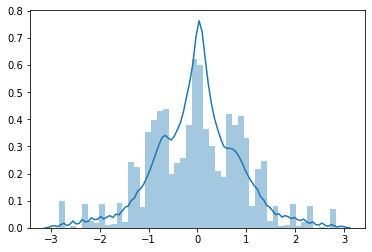

In [70]:
sns.distplot(av_coords[:,2].cpu(), hist_kws={'weights': data.y[subset_ind].cpu()})

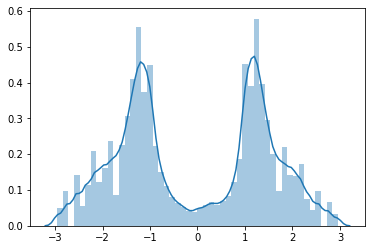

In [231]:
sns.distplot(av_coords[:,2].cpu())

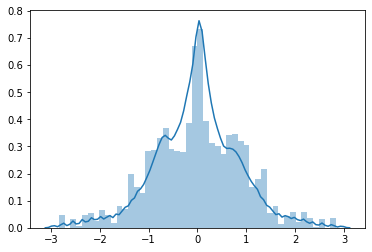

In [69]:
sns.distplot(av_coords[:,2].cpu(), hist_kws={'weights': preds.float().cpu()})

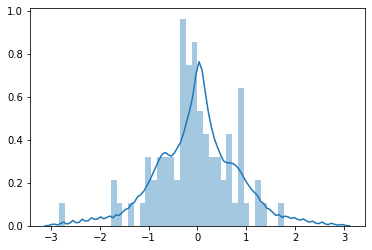

In [74]:
sns.distplot(av_coords[:,2].cpu(), hist_kws={'weights': (data.y[subset_ind].bool().cpu() & ~preds.cpu()).float()})

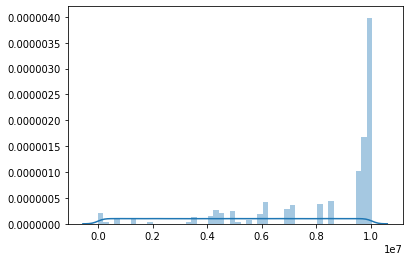

In [77]:
sns.distplot(subset_ind, hist_kws={'weights': preds.float().cpu()})

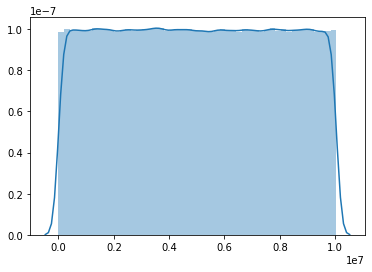

In [36]:
sns.distplot(subset_ind)

In [25]:
(F.sigmoid(output) > 0.3).sum()

tensor(119409, device='cuda:0')

In [41]:
sample.edge_index

tensor([[   109,    559,   5044,  ..., 103302, 103302, 100242],
        [     0,      0,      0,  ...,  63199,  90855, 103302]],
       device='cuda:0')

In [19]:
sample.layerless_true_edges.shape

torch.Size([2, 123429])

In [17]:
sample.y.sum()

tensor(120268., device='cuda:0')

In [95]:
sample = torch.load(all_events[0], map_location="cpu")

In [106]:
def construct_downstream(batch, pl_module):

    emb = (None if (pl_module.hparams["emb_channels"] == 0)
           else batch.embedding)  # Does this work??
    
    sections = 16
    cut_list = []
    for j in range(sections):
#         print(j)
        subset_ind = torch.chunk(torch.arange(batch.e_radius.shape[1]), sections)[j]
        output = pl_module(torch.cat([batch.cell_data, batch.x], axis=-1), batch.e_radius[:, subset_ind], emb).squeeze() if ('ci' in pl_module.hparams["regime"]) else pl_module(batch.x, batch.e_radius[:, subset_ind], emb).squeeze()
        av_coords = (batch.x[batch.e_radius[0,subset_ind]] + batch.x[batch.e_radius[1,subset_ind]])/2
#         dynamic_cut = torch.tensor([0.05]*len(subset_ind), device=device)
#         dynamic_cut[((av_coords[:,2] < 0.5) & (av_coords[:,2] > -0.5))] = 0.01
        dynamic_cut = 0.15
#         dynamic_cut = 0.1 if (9 <= j < 14) else 0.1
        cut = F.sigmoid(output) > dynamic_cut
        cut_list.append(cut)
#     print("Predicted!")
    y_pid = batch.pid[batch.e_radius[0]] == batch.pid[batch.e_radius[1]]
    cut_list = torch.cat(cut_list)
    batch.edge_index = batch.e_radius[:, cut_list]
#     batch.e_radius = None
    batch.embedding = None
    batch.y_filter = batch.y[cut_list]
    
    return batch

In [107]:
with torch.no_grad():
    processed = construct_downstream(sample.to(device), model)

In [108]:
processed.y_filter.sum() / processed.y.sum()

tensor(0.9613, device='cuda:0')

In [109]:
processed.y_filter.sum() / processed.layerless_true_edges.shape[1]

tensor(0.9366, device='cuda:0')

In [110]:
processed.y_filter.sum() / len(processed.y_filter)

tensor(0.0563, device='cuda:0')

In [111]:
processed.y_filter.shape

torch.Size([2053390])

In [203]:
processed.y_filter.sum() / processed.y.sum()

tensor(0.9879, device='cuda:0')

In [204]:
processed.y_filter.sum() / processed.layerless_true_edges.shape[1]

tensor(0.9626, device='cuda:0')

In [205]:
processed.y_filter.sum() / len(processed.y_filter)

tensor(0.0314, device='cuda:0')

In [23]:
with torch.no_grad():
    batch = sample.to(device)

    emb = (None if (model.hparams["emb_channels"] == 0)
           else batch.embedding)  # Does this work??

    sections = 8
    cut_list = []
    for j in range(sections):
    #         print(j)
        subset_ind = torch.chunk(torch.arange(batch.e_radius.shape[1]), sections)[j]
        output = model(torch.cat([batch.cell_data, batch.x], axis=-1), batch.e_radius[:, subset_ind], emb).squeeze() if ('ci' in model.hparams["regime"]) else model(batch.x, batch.e_radius[:, subset_ind], emb).squeeze()
        cut = F.sigmoid(output) > model.hparams["filter_cut"]
        cut_list.append(cut)
    #     print("Predicted!")
    y_pid = batch.pid[batch.e_radius[0]] == batch.pid[batch.e_radius[1]]
    cut_list = torch.cat(cut_list)
    batch.edge_index = batch.e_radius[:, cut_list]
    batch.e_radius = None
    batch.embedding = None
    if "pid" not in model.hparams["regime"]:
        batch.y = batch.y[cut_list]
    else:
        batch.y = None
    batch.y_pid = y_pid[cut_list]

In [160]:
with torch.no_grad():
    batch = sample.to(device)

    emb = (None if (model.hparams["emb_channels"] == 0)
           else batch.embedding)  # Does this work??

    sections = 16
    cut_list = []
    for j in range(sections):
        print(j)
        subset_ind = torch.chunk(torch.arange(batch.e_radius.shape[1]), sections)[j]
        output = model(torch.cat([batch.cell_data, batch.x], axis=-1), batch.e_radius[:, subset_ind], emb).squeeze() if ('ci' in model.hparams["regime"]) else model(batch.x, batch.e_radius[:, subset_ind], emb).squeeze()
        av_coords = (batch.x[batch.e_radius[0,subset_ind]] + batch.x[batch.e_radius[1,subset_ind]])/2
#         dynamic_cut = torch.tensor([0.1]*len(subset_ind), device=device)
#         dynamic_cut[((av_coords[:,2] < 1) & (av_coords[:,2] > -1))] = 0.05
#         dynamic_cut = 0.5 if (9 <= j < 14) else 0.05
        dynamic_cut = 0.1
        cut = F.sigmoid(output) > dynamic_cut
        cut_list.append(cut)
#         print(cut.sum())
        print(batch.y[subset_ind].sum())
        print((batch.y[subset_ind].bool() & cut).sum() / batch.y[subset_ind].sum())
        print((batch.y[subset_ind].bool() & cut).sum() / cut.float().sum())
        

0
tensor(5076., device='cuda:0')
tensor(0.9354, device='cuda:0')
tensor(0.0459, device='cuda:0')
1
tensor(6405., device='cuda:0')
tensor(0.9026, device='cuda:0')
tensor(0.0601, device='cuda:0')
2
tensor(6156., device='cuda:0')
tensor(0.9581, device='cuda:0')
tensor(0.0566, device='cuda:0')
3
tensor(5700., device='cuda:0')
tensor(0.9484, device='cuda:0')
tensor(0.0486, device='cuda:0')
4
tensor(5304., device='cuda:0')
tensor(0.9327, device='cuda:0')
tensor(0.0405, device='cuda:0')
5
tensor(5270., device='cuda:0')
tensor(0.9230, device='cuda:0')
tensor(0.0424, device='cuda:0')
6
tensor(4484., device='cuda:0')
tensor(0.9349, device='cuda:0')
tensor(0.0345, device='cuda:0')
7
tensor(4497., device='cuda:0')
tensor(0.9128, device='cuda:0')
tensor(0.0341, device='cuda:0')
8
tensor(5020., device='cuda:0')
tensor(0.9709, device='cuda:0')
tensor(0.0405, device='cuda:0')
9
tensor(10126., device='cuda:0')
tensor(0.9958, device='cuda:0')
tensor(0.0903, device='cuda:0')
10
tensor(11166., device='cud

In [100]:
dynamic_cut[((av_coords[:,2] < 1) & (av_coords[:,2] > -1))]

tensor([0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000])

In [96]:
(av_coords[:,2]) < 1

tensor([True, True, True,  ..., True, True, True], device='cuda:0')

In [15]:
cut_list.shape

torch.Size([10048605])

In [22]:
sample.y.sum()

tensor(120268.)

In [25]:
sample.y.sum() / sample.layerless_true_edges.shape[1]

tensor(0.8509, device='cuda:0')

In [32]:
import matplotlib.pyplot as plt

In [33]:
r = sample.x[sample.layerless_true_edges[:,:70],0].cpu()
phi = sample.x[sample.layerless_true_edges[:,:70],1].cpu()
z = sample.x[sample.layerless_true_edges[:,:70],2].cpu()
x = r*np.cos(phi)
y = r*np.sin(phi)

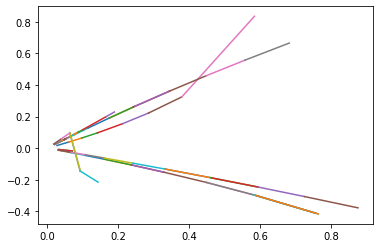

In [34]:
plt.plot(x,y);

## Build Graph Set

In [20]:
def post_process(pl_module, load_dir, save_dir):
    print("Training finished, running inference to filter graphs...")

    # By default, the set of examples propagated through the pipeline will be train+val+test set
    datatypes = ["train", "val", "test"]
    [os.makedirs(os.path.join(save_dir, datatype), exist_ok=True) for datatype in datatypes]
    
    input_dirs = [os.path.join(load_dir, datatype) for datatype in datatypes]
    loadsets = [load_dataset(input_dir) for input_dir in input_dirs]
    
    total_length = sum([len(dataset) for dataset in loadsets])
    batch_incr = 0

    pl_module.eval()
    with torch.no_grad():
        for set_idx, (datatype, dataset) in enumerate(zip(datatypes, loadsets)):
            for batch_idx, event in enumerate(dataset):
#                 print(event)
                percent = (batch_incr / total_length) * 100
                sys.stdout.flush()
                sys.stdout.write(f'{percent:.01f}% inference complete \r')
                if (not os.path.exists(os.path.join(save_dir, datatype, event[-4:]))):
                    batch = torch.load(event, map_location=torch.device('cpu'))
                    data = batch.to(pl_module.device) #Is this step necessary??
                    data = construct_downstream(data, pl_module)
                    save_downstream(data, pl_module, datatype, save_dir)

                batch_incr += 1

def construct_downstream(batch, pl_module):

    emb = (None if (pl_module.hparams["emb_channels"] == 0)
           else batch.embedding)  # Does this work??
    
    sections = 8
    cut_list = []
    for j in range(sections):
#         print(j)
        subset_ind = torch.chunk(torch.arange(batch.e_radius.shape[1]), sections)[j]
        output = pl_module(torch.cat([batch.cell_data, batch.x], axis=-1), batch.e_radius[:, subset_ind], emb).squeeze() if ('ci' in pl_module.hparams["regime"]) else pl_module(batch.x, batch.e_radius[:, subset_ind], emb).squeeze()
        cut = F.sigmoid(output) > pl_module.hparams["filter_cut"]
        cut_list.append(cut)
#     print("Predicted!")
    y_pid = batch.pid[batch.e_radius[0]] == batch.pid[batch.e_radius[1]]
    cut_list = torch.cat(cut_list)
    batch.edge_index = batch.e_radius[:, cut_list]
    batch.e_radius = None
    batch.embedding = None
    if "pid" not in pl_module.hparams["regime"]:
        batch.y = batch.y[cut_list]
    else:
        batch.y = None
    batch.y_pid = y_pid[cut_list]
    
    return batch

def save_downstream(batch, pl_module, datatype, save_dir):

    with open(os.path.join(save_dir, datatype, batch.event_file[-4:]), 'wb') as pickle_file:
        torch.save(batch, pickle_file)


In [42]:
def load_dataset(input_dir):
    all_events = os.listdir(input_dir)
    all_events = sorted([os.path.join(input_dir, event) for event in all_events])

    return all_events

In [43]:
load_dir = "/global/cscratch1/sd/danieltm/ExaTrkX/trackml_processed/embedding_processed/0_pt_cut_endcaps"
save_dir = "/global/cscratch1/sd/danieltm/ExaTrkX/trackml_processed/filter_processed/0_pt_cut_endcaps_connected"

In [44]:
post_process(model, load_dir, save_dir)

Training finished, running inference to filter graphs...


In [ ]:
model.eval()
with torch.no_grad():
    for 
        for i, batch in enumerate(train_dataset):
            tic = tt()
            if not os.path.exists(os.path.join(save_dir, batch.event_file[-4:])):
                data = batch.to(device)
                emb = (None if (hparams["emb_channels"] == 0) 
                           else data.embedding) 

                cut_list = []
                for j in range(sections):
                    subset_ind = torch.chunk(torch.arange(data.e_radius.shape[1]), sections)[j]
    #                 print(subset_ind)
                    output = model(torch.cat([data.cell_data, data.x], axis=-1), data.e_radius[:, subset_ind], emb).squeeze() if ('ci' in hparams["regime"]) else model(data.x, data.e_radius[:, subset_ind], emb).squeeze()
                    cut = F.sigmoid(output) > 0.35
                    cut_list.append(cut)

                cut_list = torch.cat(cut_list)
                batch.edge_index = batch.e_radius[:, cut_list]
                batch.e_radius = None
                batch.embedding = None
        #         batch.x = batch.x.cpu()
        #         batch.y = torch.from_numpy(y[combined_indices]).float()
                batch.y = batch.y[cut_list]

                with open(os.path.join(save_dir, batch.event_file[-4:]), 'wb') as pickle_file:
                    torch.save(batch, pickle_file)

            print(i, "saved in time", tt()-tic)
    #         break

In [55]:
import numpy as np
from numpy.random import shuffle, choice
from time import time as tt
import os

save_dir = "/global/cscratch1/sd/danieltm/ExaTrkX/trackml_processed/filter_processed/0_pt_cut_endcaps/train"
train, ratio = False, 8

model.eval()
with torch.no_grad():
    for i, batch in enumerate(model.train_dataloader().dataset):
            tic = tt()
            if not os.path.exists(os.path.join(save_dir, batch.event_file[-4:])):

                data = batch.to(device)
                if 'ci' in model.hparams['regime']:
                    spatial = model(torch.cat([data.cell_data, data.x], axis=-1))
                else:
                    spatial = model(data.x)
                e_spatial = build_edges(spatial, 1.7, 500, res)  
                e_bidir = torch.cat([batch.layerless_true_edges.to(device), 
                                       torch.stack([batch.layerless_true_edges[1], batch.layerless_true_edges[0]], axis=1).T.to(device)], axis=-1) 
                e_spatial, y_cluster = graph_intersection(e_spatial, e_bidir)

                # Remove duplicate edges by distance from vertex
                R_dist = torch.sqrt(batch.x[:,0]**2 + batch.x[:,2]**2)
                e_spatial = e_spatial[:, (R_dist[e_spatial[0]] < R_dist[e_spatial[1]])]

                e_spatial, y = graph_intersection(e_spatial, e_bidir)  

                # Re-introduce random direction, to avoid training bias
                random_flip = torch.randint(2, (e_spatial.shape[1],)).bool()
                e_spatial[0, random_flip], e_spatial[1, random_flip] = e_spatial[1, random_flip], e_spatial[0, random_flip]

                batch.embedding = spatial.cpu().detach()

                if train and (ratio != 0): # Sample only ratio:1 fake:true edges, to keep trainset manageable

                    num_true = y.sum()
                    fake_indices = choice(np.where(~y)[0], int(num_true*ratio), replace=True)
                    true_indices = np.where(y)[0]
                    combined_indices = np.concatenate([true_indices, fake_indices])
                    shuffle(combined_indices)

                    batch.e_radius = e_spatial[:,combined_indices].cpu()
                    batch.y = torch.from_numpy(y[combined_indices]).float()

                else:
                    batch.e_radius = e_spatial.cpu()
                    batch.y = torch.from_numpy(y).float()


                with open(os.path.join(save_dir, batch.event_file[-4:]), 'wb') as pickle_file:
                    torch.save(batch, pickle_file)

                print(i, "saved in time", tt()-tic, "with efficiency", (batch.y.sum()/batch.layerless_true_edges.shape[1]).item(), "and purity", (batch.y.sum()/batch.e_radius.shape[1]).item())

            else:
                print(i, "already built")

0 already built
1 already built
2 already built
3 already built
4 already built
5 already built
6 already built
7 already built
8 already built
9 already built
10 already built
11 already built
12 already built
13 already built
14 already built
15 already built
16 already built
17 already built
18 already built
19 already built
20 already built
21 already built
22 already built
23 already built
24 already built
25 already built
26 already built
27 already built
28 already built
29 already built
30 already built
31 already built
32 already built
33 already built
34 already built
35 already built
36 already built
37 already built
38 already built
39 already built
40 already built
41 already built
42 already built
43 already built
44 already built
45 already built
46 already built
47 already built
48 already built
49 already built
50 already built
51 already built
52 already built
53 already built
54 already built
55 already built
56 already built
57 already built
58 already built
59 save

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/global/homes/d/danieltm/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-55-89672923ace6>", line 29, in <module>
    e_spatial, y = graph_intersection(e_spatial, e_bidir)
  File "/global/u2/d/danieltm/ExaTrkX/Tracking-ML-Exa.TrkX/src/Pipelines/Examples/LightningModules/Embedding/utils.py", line 14, in graph_intersection
    l1 = pred_graph.cpu().numpy()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/global/homes/d/danieltm/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  

KeyboardInterrupt: 

# GNN

In [3]:
with open("LightningModules/GNN/train_gnn.yaml") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [4]:
model = ResAGNN(config)

Optionally load the Weights & Biases logger

In [5]:
wandb_logger = WandbLogger(project=config["project"], group="LayerlessEndcaps", log_model=True, save_dir = config["wandb_save_dir"])

## Callback Testing

In [6]:
trainer = pl.Trainer(max_epochs = config['max_epochs'], gpus=1, logger=wandb_logger, callbacks=stringlist_to_classes(config["callbacks"]))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [7]:
trainer.fit(model)

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Currently logged in as: murnanedaniel (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.10.2
wandb: Run data is saved locally in /global/cscratch1/sd/danieltm/ExaTrkX/wandb_data/wandb/run-20201015_102508-z9d4id5q
wandb: Syncing run neat-serenity-10


Set SLURM handle signals.

  | Name          | Type        | Params
----------------------------------------------
0 | input_network | Sequential  | 192   
1 | edge_network  | EdgeNetwork | 5 K   
2 | node_network  | NodeNetwork | 5 K   


Saving latest checkpoint..


1

In [8]:
torch.cuda.max_memory_allocated() / 1024**3

10.211020469665527

## Model Load and Test

In [12]:
import torch.nn.functional as F

In [13]:
run_label = "oew8m1sj"
wandb_dir = "/global/cscratch1/sd/danieltm/ExaTrkX/wandb_data"

In [14]:
best_run_path = get_best_run(run_label,wandb_dir)

In [15]:
chkpnt = torch.load(best_run_path)

In [16]:
model = SplitCheckpointedResAGNN(chkpnt["hyper_parameters"])

In [17]:
model = model.load_from_checkpoint(best_run_path)

In [20]:
model.learning_rate

AttributeError: 'SplitCheckpointedResAGNN' object has no attribute 'learning_rate'

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [38]:
model.eval()
with torch.no_grad():
    edge_total_positive, edge_total_true, edge_total_true_positive = 0, 0, 0
    for i, batch in enumerate(model.val_dataloader()):
            data = batch.to(device)
                
            emb = (None if (model.hparams["emb_channels"] == 0) 
                   else data.embedding) 
        
            subset_ind = torch.randint(data.e_radius.shape[1], (int(data.e_radius.shape[1]*model.hparams['val_subset']),))

            output = model(torch.cat([data.cell_data, data.x], axis=-1), data.e_radius[:, subset_ind], emb).squeeze() if ('ci' in model.hparams["regime"]) else model(data.x, data.e_radius[:, subset_ind], emb).squeeze()

            val_loss = F.binary_cross_entropy_with_logits(output, data.y[subset_ind])

            result = pl.EvalResult(checkpoint_on=val_loss)
            result.log('val_loss', val_loss)

            #Edge filter performance
            preds = F.sigmoid(output) > 0.3 #Maybe send to CPU??
            edge_positive = preds.sum().float()
            if ('pid' in model.hparams["regime"]):
                y_pid = data.pid[data.e_radius[0,subset_ind]] == batch.pid[data.e_radius[1,subset_ind]]
                edge_true = y_pid.sum()
                edge_true_positive = (y_pid & preds).sum().float()
            else:
                edge_true = data.y[subset_ind].sum()
                edge_true_positive = (data.y[subset_ind].bool() & preds).sum().float()
            
            edge_total_positive += edge_positive
            edge_total_true += edge_true
            edge_total_true_positive += edge_true_positive
            
            if i % 5 == 0:
                print(i, "validated")

    edge_eff = (edge_total_true_positive / max(edge_total_true, 1))
    edge_pur = (edge_total_true_positive / max(edge_total_positive, 1))

0 validated
5 validated


In [39]:
edge_eff, edge_pur

(tensor(0.9926, device='cuda:0'), tensor(0.1092, device='cuda:0'))

## Load Training Checkpoint

In [3]:
run_id = "oew8m1sj"
wandb_dir = "/global/cscratch1/sd/danieltm/ExaTrkX/wandb_data"

In [4]:
best_run_path = get_best_run(run_id,wandb_dir)

In [5]:
chkpnt = torch.load(best_run_path)

In [6]:
model = SplitCheckpointedResAGNN(chkpnt["hyper_parameters"])

Optionally load the Weights & Biases logger

In [10]:
model_filepath = os.path.join("/global/cscratch1/sd/danieltm/ExaTrkX/lightning_checkpoints", chkpnt["hyper_parameters"]["project"], run_id)
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    filepath=model_filepath,
    save_top_k=3,
    save_last=True,
    mode='min')

In [11]:
wandb_logger = WandbLogger(project=chkpnt["hyper_parameters"]["project"], group="LayerlessEndcaps", save_dir = wandb_dir, id=run_id)

In [12]:
trainer = pl.Trainer(resume_from_checkpoint=best_run_path, max_epochs = chkpnt["hyper_parameters"]['max_epochs'], gpus=1, logger=wandb_logger, checkpoint_callback=checkpoint_callback)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [13]:
trainer.fit(model)

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Currently logged in as: murnanedaniel (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.8 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.10.2
wandb: Run data is saved locally in /global/cscratch1/sd/danieltm/ExaTrkX/wandb_data/wandb/run-20201022_162229-oew8m1sj
wandb: Resuming run usual-disco-51


Set SLURM handle signals.

  | Name         | Type       | Params
--------------------------------------------
0 | node_encoder | Sequential | 288   
1 | edge_network | Sequential | 9 K   
2 | node_network | Sequential | 9 K   


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2aab18749cb0>
Traceback (most recent call last):
  File "/global/homes/d/danieltm/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/global/homes/d/danieltm/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/multiprocessing/popen_fork.py", line 48, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 
Saving latest checkpoint..


1